# Video Analysis

##### Author: Prashant Mittal

---

### Models and Dataset

In this notebook, I have implemented two types of architectures for video analysis:
* CNN + LSTM (ConvLSTM2D)
* EfficientNet.

For training the models, I utilized the UCF101 dataset, which contains a collection of videos classified into 101 different action classes. The dataset consists of a total of 13,320 videos. However, I specifically selected videos from only 5 types of actions for training. If you prefer, you can explore training with the full dataset or choose a subset of actions that you are interested in.

Please note that the UCF101 dataset can be accessed from this Kaggle [link](https://www.kaggle.com/datasets/pevogam/ucf101/download?datasetVersionNumber=1).

Extract the zip inside a "input" folder.

---

### CNN + LSTM (ConvLSTM2D)

#### Import Packages

In [1]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping

#### Lables File and Dataset Path

In [2]:
label_data = pd.read_csv("input/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
label_data = label_data.drop(['index'], axis=1)

path=[]
for label in label_data.labels.values:
    path.append('input/UCF101/UCF-101/'+label+"/")

#### Feature Extractor and Video Loader

In [3]:
def feature_extraction(video_path):
    width = 60
    height = 60
    sequence_length = 10
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_interval = max(int(frame_count / sequence_length), 1)
    for counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        ret, frame = video_reader.read()
        if not ret:
            break
        frame = cv2.resize(frame, (height, width))
        frame = frame / 255
        frames_list.append(frame)
    video_reader.release()
    return frames_list

def load_video(datasets):
    label_index = 0
    labels = []
    images = []
    for folder in datasets:
        for file in os.listdir(folder):
            video_path = os.path.join(folder, file)
            frames_list = feature_extraction(video_path)
            images.append(frames_list)
            labels.append(label_index)
        label_index += 1
    return np.array(images, dtype='float16'), np.array(labels, dtype='int8')

The function "feature_extraction" extracts frames from a video file. It reads the video, calculates the total number of frames, and determines the interval for frame extraction based on the desired sequence length. It then iterates through the frames, resizing and normalizing them before adding them to a list. Finally, it releases the video reader and returns the list of frames.

Sequence length is important as it determines the number of frames used to represent the video. It helps manage memory constraints, the length of the video, and the relevance of frames. By specifying a sequence length, we can balance the amount of information extracted and the computational resources required.

The function "load_video" loads video files from datasets, extracts frames, and stores them along with their label indices. It iterates through the folders and video files, extracts frames using the feature_extraction function, and appends frames and labels to respective lists. Finally, it returns the frames and labels as numpy arrays in a tuple.

#### Split Dataset into Train and Test

In [4]:
images, labels = load_video(path[:5])

x_train, x_test, y_train, y_test=train_test_split(images, labels, test_size=0.06, random_state=10)
x_train.shape, x_test.shape, np.array(y_train).shape, np.array(y_test).shape

((605, 10, 60, 60, 3), (39, 10, 60, 60, 3), (605,), (39,))

#### Building Model

In [5]:
model = Sequential()

model.add(BatchNormalization(momentum=0.8, input_shape=(x_train.shape[1],x_train.shape[2], x_train.shape[3], 3)))
model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.2)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(ConvLSTM2D(filters = 16, kernel_size=(3,3), activation='LeakyReLU', data_format='channels_last', return_sequences=True, recurrent_dropout=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(MaxPooling3D(pool_size=(1,2,2), padding='same', data_format='channels_last'))
model.add(TimeDistributed(Dropout(0.3)))

model.add(Flatten())

model.add(Dense(4096,activation="relu"))
    
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 10, 60, 60, 3)    12        
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 58, 58, 16)    11008     
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 29, 29, 16)   0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 10, 29, 29, 16)   0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 27, 27, 16)    18496     
                                                        

The Convolutional Long Short-Term Memory (ConvLSTM) model is used for video classification. It includes layers such as ConvLSTM2D, MaxPooling3D, Dropout, BatchNormalization, and Dense.

The input is a sequence of video frames. The model applies convolutional filters and LSTM algorithm to process sequential information. MaxPooling3D layers downsample the data, Dropout layers prevent overfitting, and BatchNormalization layers normalize the activities of previous layers.

The model ends with a Flatten layer, followed by two Dense layers. The first Dense layer has 4096 units with ReLU activation, and the second Dense layer has 5 units with softmax activation for classification.

Overall, the ConvLSTM model extracts features from video frames and uses LSTM to model temporal dependencies, enabling video classification.

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

#### Train Model with EarlyStopping

In [7]:
es = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)
history = model.fit(x_train, to_categorical(y_train), batch_size=32, epochs=50, validation_data=(x_test, to_categorical(y_test)), callbacks=[es])

Epoch 1/50
19/19 [==============================] - 87s 4s/step - loss: 3.0029 - accuracy: 0.3917 - val_loss: 2.1926 - val_accuracy: 0.3077
Epoch 2/50
19/19 [==============================] - 83s 4s/step - loss: 1.2815 - accuracy: 0.6000 - val_loss: 1.0668 - val_accuracy: 0.6410
Epoch 3/50
19/19 [==============================] - 79s 4s/step - loss: 0.8823 - accuracy: 0.7008 - val_loss: 0.6419 - val_accuracy: 0.6923
Epoch 4/50
19/19 [==============================] - 78s 4s/step - loss: 0.7170 - accuracy: 0.7488 - val_loss: 0.6802 - val_accuracy: 0.6667
Epoch 5/50
19/19 [==============================] - 77s 4s/step - loss: 0.6386 - accuracy: 0.7934 - val_loss: 0.3572 - val_accuracy: 0.8462
Epoch 6/50
19/19 [==============================] - 77s 4s/step - loss: 0.4195 - accuracy: 0.8347 - val_loss: 0.3240 - val_accuracy: 0.9231
Epoch 7/50
19/19 [==============================] - 78s 4s/step - loss: 0.3306 - accuracy: 0.8777 - val_loss: 0.2572 - val_accuracy: 0.8974
Epoch 8/50
19/19 [==

The EarlyStopping callback function is used to monitor the validation loss during model training and stop the training process if the validation loss does not improve for a certain number of epochs.

The callback function takes parameters such as monitor, which specifies the quantity to be monitored (in this case, the validation loss), patience, which determines the number of epochs to wait before stopping training if the validation loss doesn't improve, mode, which specifies whether the monitored quantity should be minimized or maximized, and restore_best_weights, which determines whether to restore the model weights to the best (lowest validation loss) after training has stopped.

For example, if we use this EarlyStopping callback function in training a model, it will monitor the validation loss at each epoch and stop training if the validation loss doesn't improve for 5 epochs. If restore_best_weights is set to True, it will also restore the model weights to the best (lowest validation loss) after training has stopped.

#### Accuracy Graph and Test accuracy

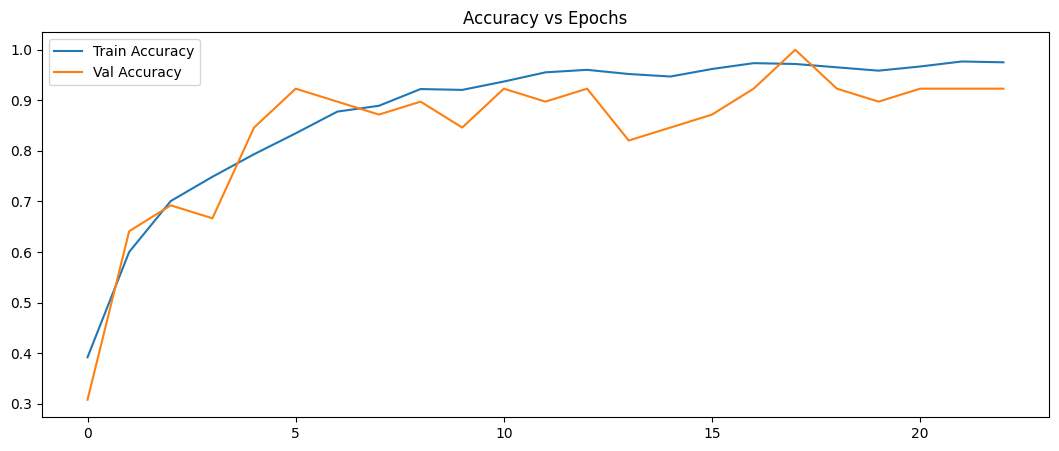

2/2 [==============================] - 1s 128ms/step
Accuary: 1.0


In [8]:
plt.figure(figsize=(13,5))
plt.title("Accuracy vs Epochs")
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(loc='best')
plt.show()

y_pred = model.predict(x_test)
predicted_classes=[]
for i in range(len(y_test)):
    predicted_classes.append(np.argmax(y_pred[i]))

print("Accuary:", accuracy_score(y_test, predicted_classes))

#### Confusion Matrix

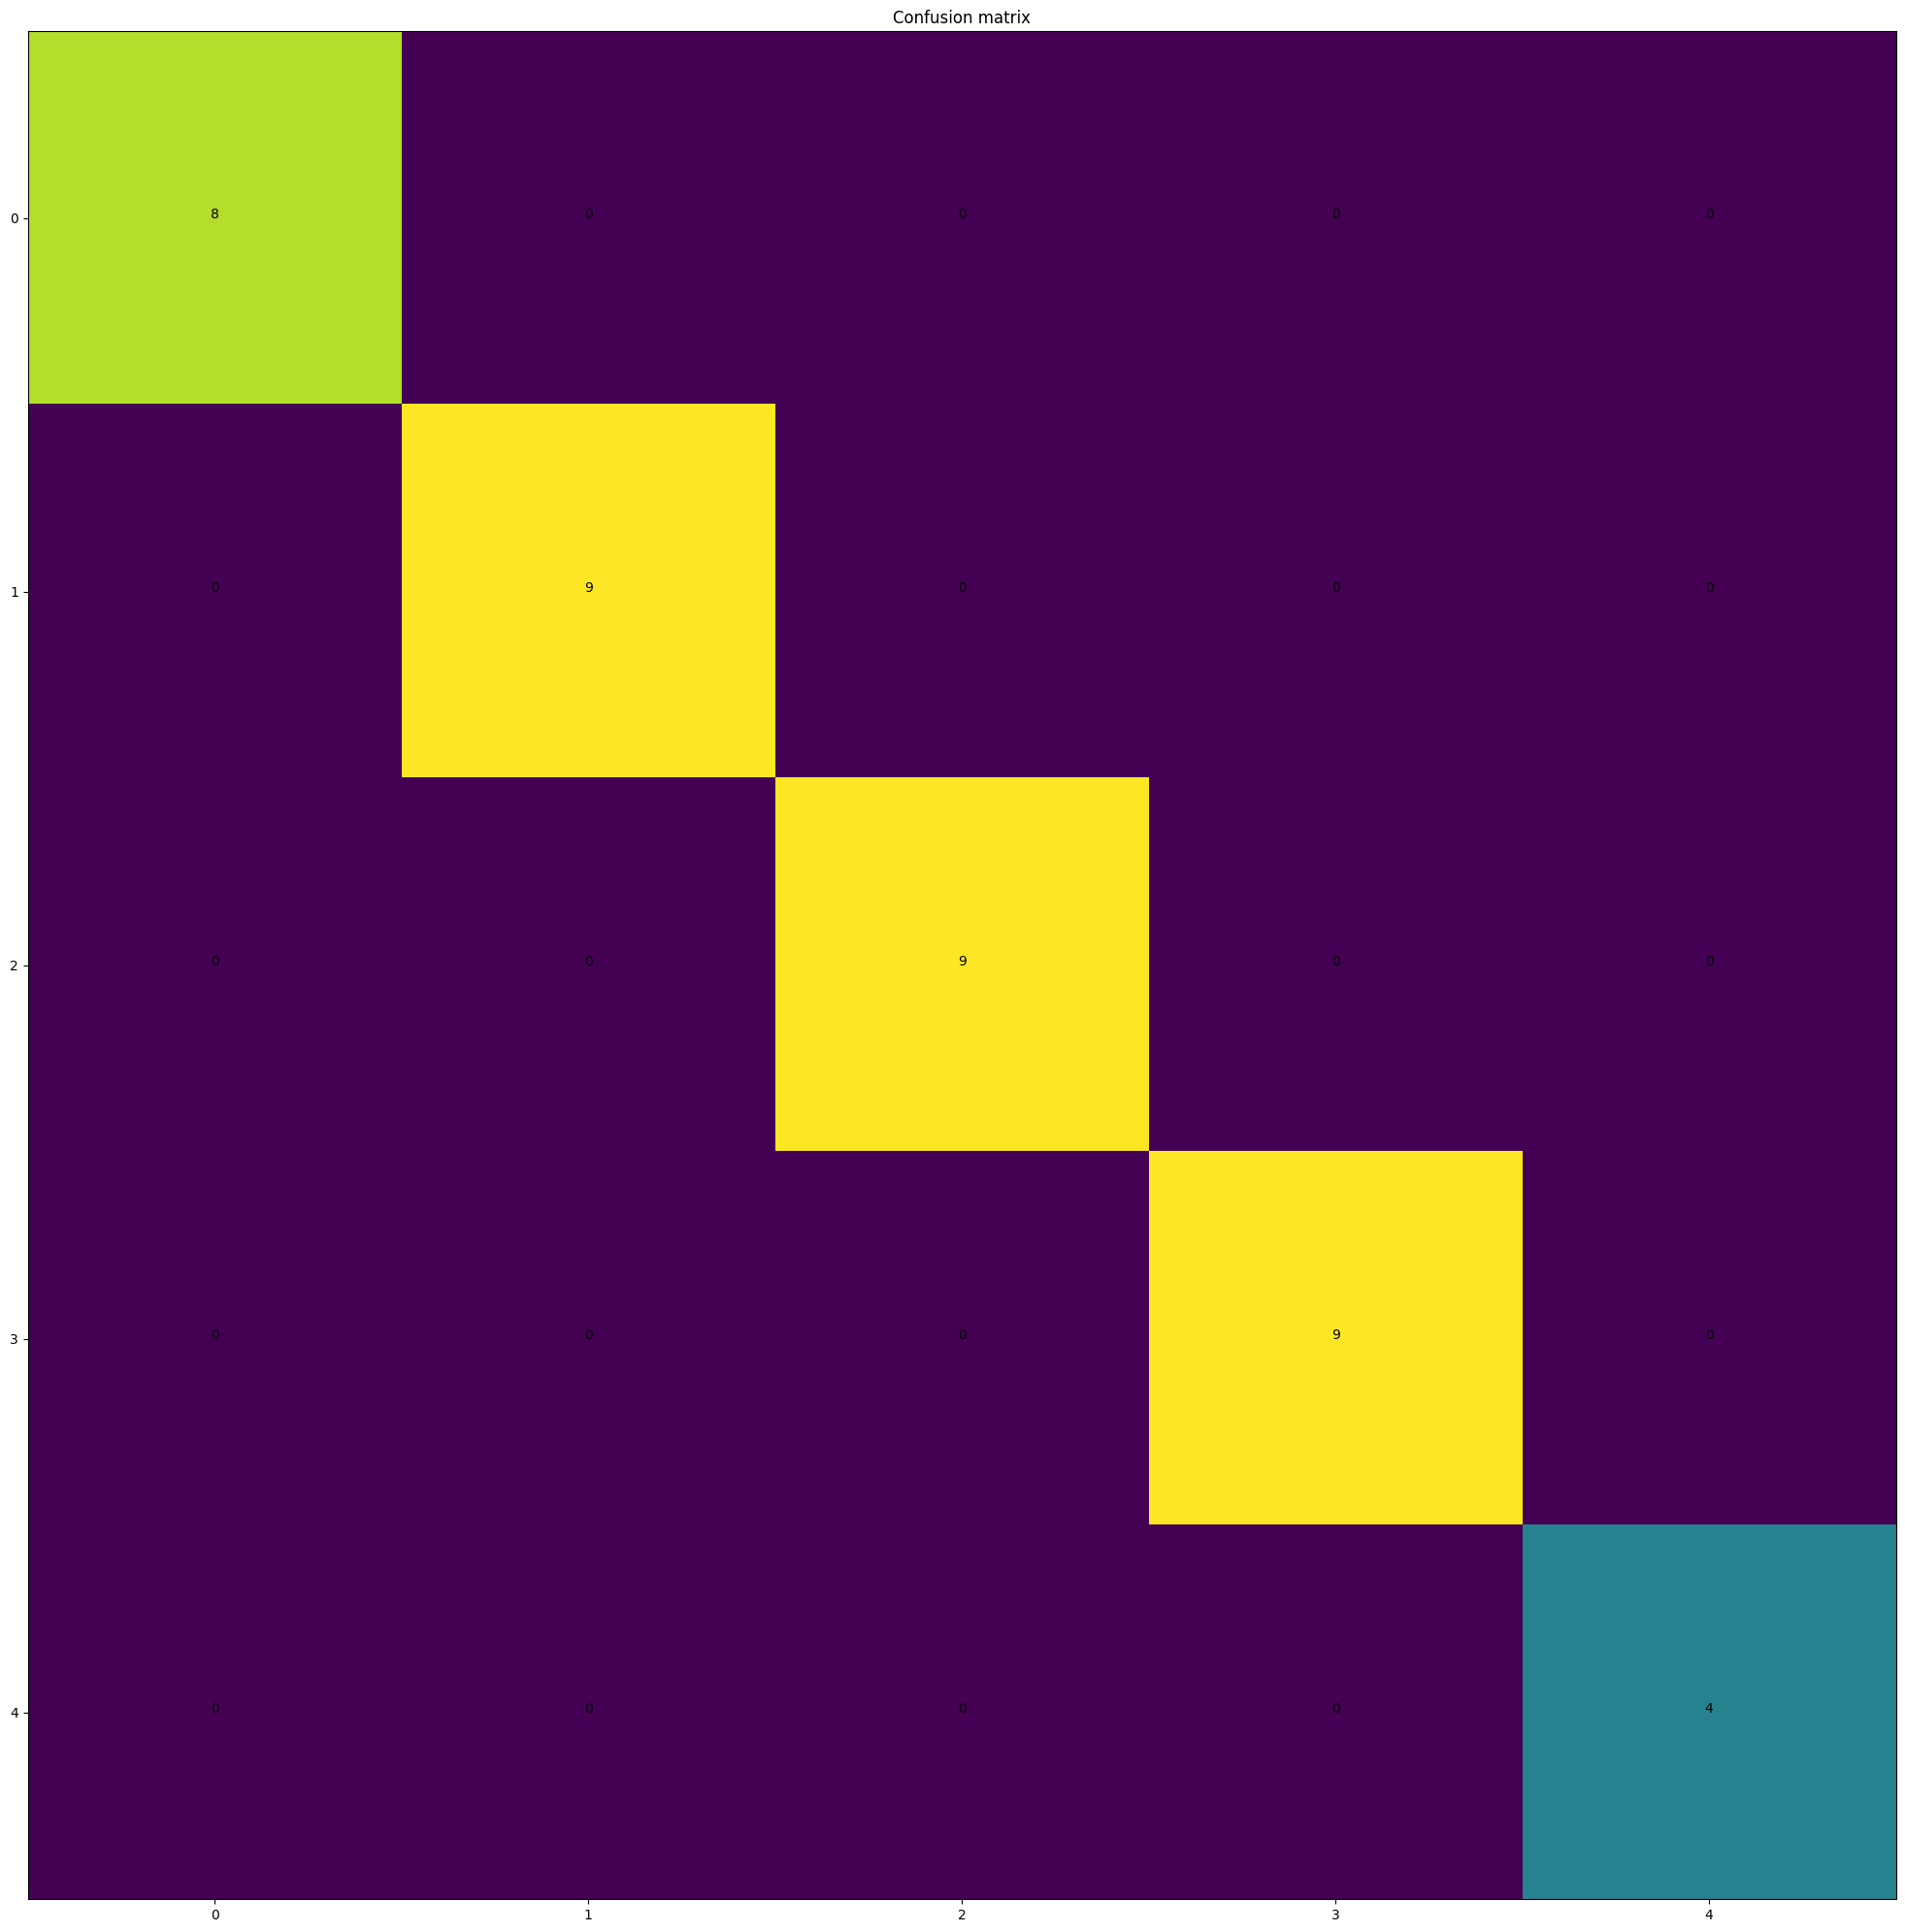

In [9]:
plt.figure(figsize=(25,25))
plt.title("Confusion matrix")
cm=confusion_matrix(y_test, predicted_classes)
plt.imshow(cm)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center")
plt.show()

---

### EfficientNet

#### Import Packages

In [10]:
import glob
import pandas as pd
import cv2
import numpy as np
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

#### Format Frames and Video File Frames

In [11]:
def format_frames(frame, output_size):
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=15):
  result = []
  src = cv2.VideoCapture(str(video_path))
  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)
  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

The "format_frames" function takes an image frame and resizes it with padding using the specified output_size. It converts the image to float32 data type and performs the resizing operation.

The "frames_from_video_file" function reads frames from a video file. It starts by setting the desired starting frame based on the n_frames and frame_step parameters. It reads the frames from the video, performs formatting using format_frames, and appends them to the result list. If there are fewer frames in the video, it pads the remaining frames with zeros. Finally, it converts the result to a NumPy array and adjusts the color channel order.

The function returns a NumPy array of frames in the shape of (n_frames, height, width, channels).

#### Dataset Path and Classes

In [12]:
classes = ["ApplyEyeMakeup", "ApplyLipstick", "Archery", "BabyCrawling", "BalanceBeam"]

file_paths = []
targets = []
for i, cls in enumerate(classes):
    sub_file_paths = glob.glob(f"input/UCF101/UCF-101/{cls}/**.avi")
    file_paths += sub_file_paths
    targets += [i] * len(sub_file_paths)

#### Extract Video Files Features

In [13]:
features = []
for file_path in tqdm(file_paths):
    features.append(frames_from_video_file(file_path, n_frames = 10))
features = np.array(features)

  0%|          | 0/644 [00:00<?, ?it/s]

#### Split Dataset into Train and Test

In [14]:
train_features, val_features, train_targets, val_targets = train_test_split(features, targets, test_size=0.2, random_state=42)
train_ds = tf.data.Dataset.from_tensor_slices((train_features, train_targets)).shuffle(128).batch(32).cache().prefetch(tf.data.AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((val_features, val_targets)).batch(32).cache().prefetch(tf.data.AUTOTUNE)

#### Building Model

In [15]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

efficient_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(255.0),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(5),
    tf.keras.layers.GlobalAveragePooling3D()
])

efficient_net_model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])


#### Train Model using EarlyStopping

In [16]:
history = efficient_net_model.fit(
    train_ds,
    epochs = 10,
    validation_data=valid_ds,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'),
        tf.keras.callbacks.ModelCheckpoint(
            "efficient_net_model.h5", 
            monitor="val_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True
        )
    ]
)

Epoch 1/10
17/17 [==============================] - 176s 10s/step - loss: 1.1211 - accuracy: 0.6718 - val_loss: 0.6910 - val_accuracy: 0.8760
Epoch 2/10
17/17 [==============================] - 161s 10s/step - loss: 0.4671 - accuracy: 0.9631 - val_loss: 0.3841 - val_accuracy: 0.9690
Epoch 3/10
17/17 [==============================] - 162s 10s/step - loss: 0.2751 - accuracy: 0.9864 - val_loss: 0.2720 - val_accuracy: 0.9690
Epoch 4/10
17/17 [==============================] - 184s 11s/step - loss: 0.1947 - accuracy: 0.9903 - val_loss: 0.2156 - val_accuracy: 0.9845
Epoch 5/10
17/17 [==============================] - 277s 17s/step - loss: 0.1517 - accuracy: 0.9942 - val_loss: 0.1821 - val_accuracy: 0.9845
Epoch 6/10
17/17 [==============================] - 163s 10s/step - loss: 0.1250 - accuracy: 0.9922 - val_loss: 0.1573 - val_accuracy: 0.9845
Epoch 7/10
17/17 [==============================] - 166s 10s/step - loss: 0.1049 - accuracy: 0.9942 - val_loss: 0.1388 - val_accuracy: 0.9845
Epoch 

#### Validation Loss and Accuracy

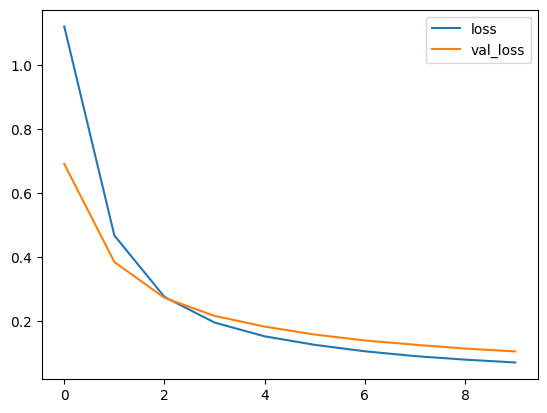

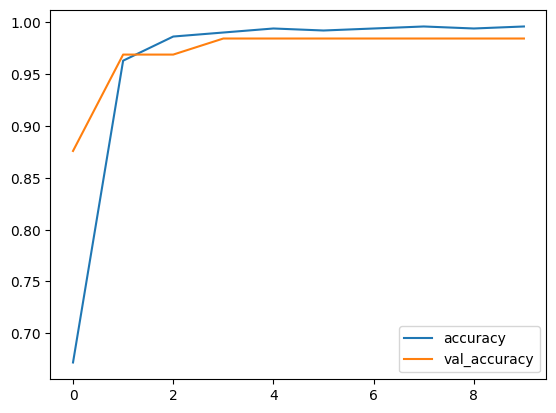

5/5 [==============================] - 32s 6s/step - loss: 0.1045 - accuracy: 0.9845
Validation Loss:0.10448019951581955 Validation Accuracy:0.9844961166381836


In [17]:
for metrics in [("loss", "val_loss"), ("accuracy", "val_accuracy")]:
    pd.DataFrame(history.history, columns=metrics).plot()
    plt.show()

val_loss, val_acc = efficient_net_model.evaluate(valid_ds)
print(f"Validation Loss:{val_loss} Validation Accuracy:{val_acc}")

---

### Conclusion

In this notebook, two types of video analysis models have been implemented:
* CNN + LSTM (ConvLSTM2D)
* EfficientNet

The EfficientNet model architecture is particularly useful when working with a small training sample size as it can enhance the accuracy of video classification models.

By leveraging these two architectures, the notebook aims to provide powerful tools for analyzing and classifying videos.